# Exercise 1: ECG prediction

Let's work on an example using ECG recordings, in order to illustrate K-fold cross validation and model selection.

The dataset is composed of two files, one for normal ECG, one for abnormal ECG.
The last column of the dataset is giving the class: 1 for abnormal ECG, 0 for normal ECG.

We will consider this example as a classification problem. In order to reduce computation time, we select the first 4000 samples of each file.

1/ Load the data, plot some normal and abnormal ECGs

2/ Split the data into a training set and a testing set (80/20)

3/ Perform PCA on your training set and plot the explained variance ratio of the components of the PCA. Decide on a number of components and compress your data using PCA.

Train a first classifier using Suport Vector Machine (class SVC in sklearn with gamma = 'auto'), with the training data compressed through PCA. Evaluate on your test set.

4/ Now we will generalize this approach with K-fold cross validation. 
Use sklearn's KFold class to split your dataset set into 6 folds.

5/ Evaluate your classifier on the whole dataset, using k-fold cross-validation. 

6/ Model selection: evaluate your model for different values for hyperparameters:
- number of pca components (10, 20, 30, 40 or 60 components)
- pca whitening: True or False
- kernel type for the SVC: 'linear', 'poly', 'rbf', 'sigmoid'

6.1/ optional: run your best model 10 times with different folds each time.

7/ Select the best model, train it using 10 folds cross validation, and predict the probability of class=1 being detected on the whole training set  (using the flag probability=True). 

8/ Now, sklearn decides on itself on a classification threshold for the SVC. We could pick the classification threshold ourself to enforce certain results. 

Evaluate, for each sample in the test set, the probability of class 1. The class 1 is indeed chosen if the probability is above the classification threshold. When we vary the classification threshold, we vary our decision and the resulting false positive rate and true positive rate.

Calculate, for several values of classification threshold, the False positive rate FPR and True positive rate TPR, and plot a ROC curve.

Let's say that we want to detect 99% of the Heart diseases, what classification threshold should we select?

What does it mean then in terms of false positive rate, that is the proportion of diagnostic which were predicted as Heart disease but actually were not? (Also called probability of false alarm).

### 1/ Load the data

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.cluster import KMeans
import pandas as pd

ecg_normal = pd.read_csv('data/ptbdb_normal.csv').to_numpy()[:4000]
ecg_abnormal = pd.read_csv('data/ptbdb_abnormal.csv').to_numpy()[:4000]

ecg_data = np.concatenate( [ecg_normal, ecg_abnormal], axis = 0 )

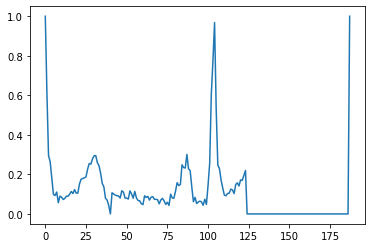

In [3]:
plt.plot(range(len(ecg_data[0,:])), ecg_data[-10,:])

### 2/ Create training and testing sets

In [4]:
import numpy.random as random

# Set the seed so that we have the same results
random.seed(0)
random.shuffle(ecg_data)

X_train = ecg_data[ :int(len(ecg_data)*0.8 ), :-1 ]
y_train = ecg_data[ :int(len(ecg_data)*0.8 ), -1 ]

X_test = ecg_data[ int(len(ecg_data)*0.8):, :-1 ]
y_test = ecg_data[ int(len(ecg_data)*0.8):, -1 ]

### 3/ Train a Classifier and evaluate the results

Compress your data using PCA, choose a number of components by plotting the explained variance ratio.

Use the vanilla version of SVC

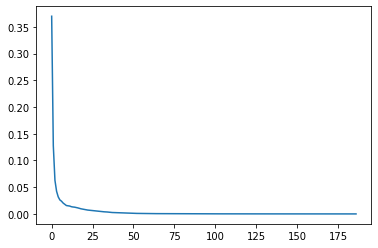

In [5]:
from sklearn.decomposition import PCA

pca = PCA()

pca.fit(X_train)

plt.plot( range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_ ) 

We choose empirically 20 components. Note that this is a subjective choice, and we don't know if this choice makes sense without actual measures.

In [6]:
pca = PCA(n_components = 20).fit(X_train)

X_train_compressed = pca.transform(X_train)
X_test_compressed = pca.transform(X_test)


In [7]:
from sklearn.svm import SVC

classifier = SVC(gamma = 'auto')
classifier.fit(X_train_compressed, y_train)

print(classifier.score( X_test_compressed, y_test))

# We can verify that the classifier is not just naively predicting the class 1 all the time, 
# by calculating the number of class one present in the dataset.
print(sum(y_test == 1) / len(y_test))


0.810625
0.498125


We are indeed clearly above chance level, so our classifier is able to learn from the data.
You can also plot the confusion matrix to verify the count of TP, FP, TN and FN.


### 4 and 5 - Generalization with K-folds cross validation

We use KFold from sklearn, but it is possible to use other built-in functions. It is also possible to do the KFold by hand, but it could be a little bit strenuous.

We evaluate our first model over the whole dataset



In [8]:
from sklearn.model_selection import KFold

X = ecg_data[ :, :-1 ]
y = ecg_data[ :, -1 ]

kf = KFold(n_splits=6, random_state=42)

score = 0

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    pca = PCA(n_components = 20).fit(X_train)
    X_train_compressed = pca.transform(X_train)
    X_test_compressed = pca.transform(X_test)
    
    classifier = SVC( gamma = 'auto')
    classifier.fit(X_train_compressed, y_train)

    score +=   classifier.score( X_test_compressed, y_test)

print('Score of our first model with K-fold: ', score/6)

Score of our first model with K-fold:  0.829749416364586


The score is not too far from the original basic test/train split.


### 6 - Model selection

We will perform model selection with these different features:
- pca (10, 20, 30, 40, 60 components)
- pca whitening or not
- kernel type
- k-fold cross validation with 6 folds

Select the best model.

In [9]:
# We create a function to clarify the code

def evaluate_model(X, y, n_comp, whitening, kernel):

    kf = KFold(n_splits=6, shuffle=True)

    score = 0

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        pca = PCA(n_components = n_comp, whiten = whitening).fit(X_train)
        X_train_compressed = pca.transform(X_train)
        X_test_compressed = pca.transform(X_test)

        classifier = SVC( kernel = kernel, gamma = 'auto')
        classifier.fit(X_train_compressed, y_train)

        score +=   classifier.score( X_test_compressed, y_test)
        
    return score/6


for kernel in ['poly', 'rbf', 'sigmoid', 'linear']:
    
    for whitening in [True, False]:
        
        for n_comp in [10, 20, 30, 40, 60]:
            
            score = evaluate_model(X, y, n_comp, whitening, kernel)
            
            
            print('Number of PCA components: ', n_comp, ', whiten: ', whitening, ', kernel: ', kernel, ', score: ', score)


Number of PCA components:  10 , whiten:  True , kernel:  poly , score:  0.8322470422703128
Number of PCA components:  20 , whiten:  True , kernel:  poly , score:  0.8801248288084015
Number of PCA components:  30 , whiten:  True , kernel:  poly , score:  0.8933763613317122
Number of PCA components:  40 , whiten:  True , kernel:  poly , score:  0.8941260802456986
Number of PCA components:  60 , whiten:  True , kernel:  poly , score:  0.8786236101754074
Number of PCA components:  10 , whiten:  False , kernel:  poly , score:  0.734002747313515
Number of PCA components:  20 , whiten:  False , kernel:  poly , score:  0.6356315465673016
Number of PCA components:  30 , whiten:  False , kernel:  poly , score:  0.5965034174585625
Number of PCA components:  40 , whiten:  False , kernel:  poly , score:  0.576876977865156
Number of PCA components:  60 , whiten:  False , kernel:  poly , score:  0.5536283808583331
Number of PCA components:  10 , whiten:  True , kernel:  rbf , score:  0.87649845369888

First observation: PCA whitening helps a lot with rbf and poly.
Ultimately, at this point we would like to perform feature selection on the PCA dimensions, instead of just selecting the first few ones. But it is out of the scope of this exercise.

Best case, in our case, is:
Number of PCA components:  30 , whiten:  True , kernel:  rbf , score:  0.9056253943545857.
The results may vary depending on your random shuffling.

Now let's draw statistics over our model: Are we just lucky with our data split or does the model generalizes well?

In [10]:

scores = []

for i in range(10):
    score = evaluate_model(X, y, 40, True, 'rbf')
    scores.append(score)
    print( 'test ', i, ':', score)
    
print('Statistics over best model: mean :', np.mean(scores), ',var: ', np.var(scores))

test  0 : 0.9095014570734138
test  1 : 0.9063764254406931
test  2 : 0.9088745199793203
test  3 : 0.9085015819172183
test  4 : 0.907375738237408
test  5 : 0.9072504257998532
test  6 : 0.9076284250972789
test  7 : 0.9082511444952693
test  8 : 0.9088746137059003
test  9 : 0.9058750819638943
Statistics over best model: mean : 0.9078509413710251 ,var:  1.2117484048436908e-06


The results are consistent, and the variance is low, which means that the accuracy of our model doesn't depend too much on the data points we picked for training and testing.

### 7 - Training and predicting

Now let's train on the whole dataset and predict on our testing set.

In order to perform more analysis, set probability = True in the SVC.

This way, we can predict the class 1 in terms of probability



In [11]:
kf = KFold(n_splits=10, shuffle=True)

y_true = []
y_pred = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    pca = PCA(n_components = 40, whiten = True).fit(X_train)
    X_train_compressed = pca.transform(X_train)
    X_test_compressed = pca.transform(X_test)

    classifier = SVC( kernel = 'rbf', gamma = 'auto', probability=True)
    pred = classifier.fit(X_train_compressed, y_train).predict_proba(X_test_compressed)[:,1]
    
    y_true.append(y_test)
    y_pred.append(pred)

In [12]:
y_true=np.concatenate(y_true)
y_pred=np.concatenate(y_pred)

Now, we can calculate the TPR and FPR in order to plot a ROC curve.

In [14]:
tp_rates = []
fp_rates = []

pos = sum(y_true == 1.0)
neg = sum(y_true == 0.0)

for t in range(0,100, 1):
    
    threshold = t/100.0
    
    classification = (y_pred > threshold)*1.0
    
    true_pos = sum((y_true == 1.0)*(classification==1.0))
    true_neg = sum((y_true == 0.0)*(classification==0.0))
    
    false_pos = sum((y_true == 0.0)*(classification==1.0))
    false_neg = sum((y_true == 1.0)*(classification==0.0))
    
    tpr = true_pos / pos
    fpr = false_pos / neg
    
    print(threshold, tpr, fpr)
    
    tp_rates.append(tpr)
    fp_rates.append(fpr)
    


0.0 1.0 1.0
0.01 0.99925 0.92225
0.02 0.9985 0.84575
0.03 0.9965 0.77875
0.04 0.99375 0.70425
0.05 0.9905 0.63125
0.06 0.986 0.552
0.07 0.98175 0.46975
0.08 0.9785 0.41275
0.09 0.977 0.3635
0.1 0.9755 0.32975
0.11 0.972 0.30275
0.12 0.96975 0.28
0.13 0.9685 0.253
0.14 0.9655 0.23475
0.15 0.96375 0.22175
0.16 0.96275 0.20975
0.17 0.96175 0.19925
0.18 0.9605 0.1895
0.19 0.9585 0.1775
0.2 0.9575 0.16875
0.21 0.95625 0.16125
0.22 0.95475 0.155
0.23 0.952 0.1485
0.24 0.95 0.14275
0.25 0.94825 0.13625
0.26 0.9465 0.13075
0.27 0.94475 0.1285
0.28 0.943 0.12475
0.29 0.9405 0.1215
0.3 0.94 0.118
0.31 0.938 0.11575
0.32 0.93575 0.11125
0.33 0.9345 0.10925
0.34 0.932 0.10675
0.35 0.9305 0.10425
0.36 0.92825 0.102
0.37 0.9255 0.099
0.38 0.9225 0.09675
0.39 0.91975 0.09475
0.4 0.91825 0.093
0.41 0.91575 0.09075
0.42 0.91425 0.08875
0.43 0.912 0.0875
0.44 0.9105 0.08575
0.45 0.909 0.0835
0.46 0.907 0.0795
0.47 0.90475 0.078
0.48 0.90325 0.07575
0.49 0.90175 0.0735
0.5 0.89825 0.07025
0.51 0.89775 0.

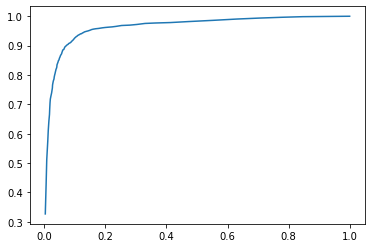

In [15]:
plt.plot(fp_rates, tp_rates)

True positive rate is the proportion of actual positives which are identified as such. In our case, we want this number to be as high as possible. Also called probability of detection.

Let's say that we want to detect 99% of the Heart diseases, what classification threshold should we select?

What does it mean then in terms of false positive rate, that is the proportion of diagnostic which were predicted as Heart disease but actually were not? Also called probability of false alarm.

We reach a false alarm rate of 60%. 
If we allow a 95% of detection, the probability of false alarm decreases to 14%.

Note that, for completeness, this classification threshold value should have been estimated on the training set, and tested on the testing set.